# DRAFT: Kriging Missing/Corrupted Pixels in Images


*** this code demo is a draft and will be updated very soon!!! The inelegant loops/repetitions will be fixed!!! ***
- First do a toy image as in https://scikit-image.org/docs/stable/auto_examples/filters/plot_inpaint.html
- Compare with inpainting, & recognize that kriging gives us ERROR ESTIMATES as well!
- Then follow up with discussion of how to fix cloud cover in vnir images cf. https://www.sciencedirect.com/science/article/pii/S1569843223000584, https://www.coastalwiki.org/wiki/Interpolation_of_remote_sensing_images, https://www.sciencedirect.com/science/article/abs/pii/0034425794900574

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2gray
from skimage.morphology import disk, binary_dilation
from skimage.restoration import inpaint
from skimage.transform import downscale_local_mean

import time

# this makes sure the images don't come out looking muddy on 
# retina displays (which your computer probably uses)
%config InlineBackend.figure_format='retina'

# set textcolor in images 
textcolor='k'

# Finally, print nice Latex labels for figures. 
# Comment these out if you don't want to wait for the tex to compile, or don't
# want to bother get tex working. 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# also, we should manually set the dpi for figures so they look good
# if saving figs, you should do so at a much higher dpi!
dpi = 300

# Example 1: Restoration of a Synthetically Corrupted Image

This closely follows the SciKit-Image tutorial referenced above, with minor changes made to accomodate using a grayscale image. 

In [2]:
# import the image and convert to grayscale
image_orig = rgb2gray(data.astronaut())
#image_orig = downscale_local_mean(image_orig, factors=(4,4))

In [3]:
# Create mask with six block defect regions
mask = np.zeros(image_orig.shape, dtype=bool)
#"""
mask[20:60, 0:20] = 1
mask[160:180, 70:155] = 1
mask[30:60, 170:195] = 1
mask[-60:-30, 170:195] = 1
mask[-180:-160, 70:155] = 1
mask[-60:-20, 0:20] = 1

# Add a few long, narrow defects
mask[200:205, -200:] = 1
mask[150:255, 20:23] = 1
mask[365:368, 60:130] = 1
mask[102:106, 240:260] = 1 # AM: I added this to the demo bcz it overlays the astronaut's left eye, so the errors from this bar 
# are much more noticeable in the fixed image
#"""

# Add randomly positioned small point-like defects
rstate = np.random.default_rng(0)
for radius in [0, 2, 4]:
    # larger defects are less common
    thresh = 3 + 0.25 * radius  # make larger defects less common
    tmp_mask = rstate.standard_normal(image_orig.shape) > thresh
    if radius > 0:
        tmp_mask = binary_dilation(tmp_mask, disk(radius, dtype=bool))
    mask[tmp_mask] = 1

# Apply defect mask to the image
image_defect = image_orig * ~mask

In [4]:
image_result = inpaint.inpaint_biharmonic(image_defect, mask)

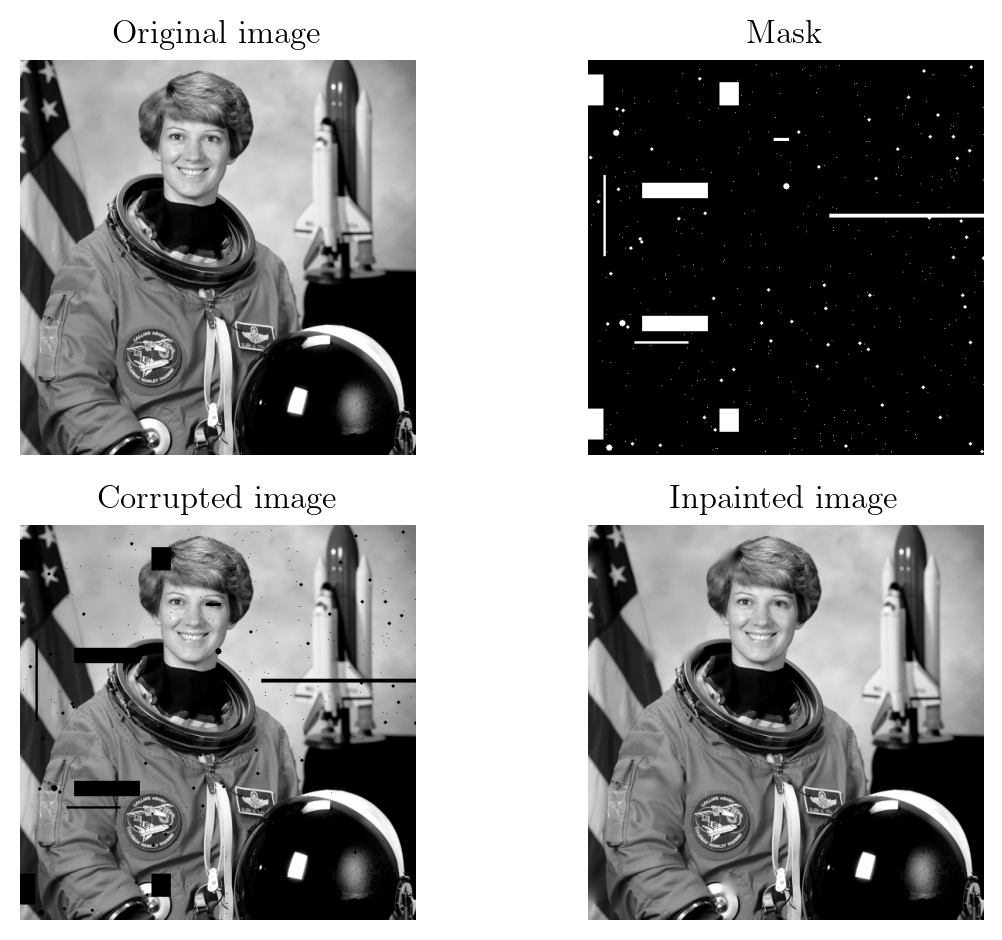

In [5]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Mask')
ax[1].imshow(mask, cmap=plt.cm.gray)

ax[2].set_title('Corrupted image')
ax[2].imshow(image_defect, cmap=plt.cm.gray)

ax[3].set_title('Inpainted image')
ax[3].imshow(image_result, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

Inpainting does a pretty good job at first glance, but on closer inspection the areas it fills in are quite blurry or inaccurate (for example, the part in the astronaut's hair, her left eye, and a thin horizontal stripe just above the round mission patch on her right-hand side). We can plot the error between the ground truth and the reconstructed image to see these discrepancies more clearly: 

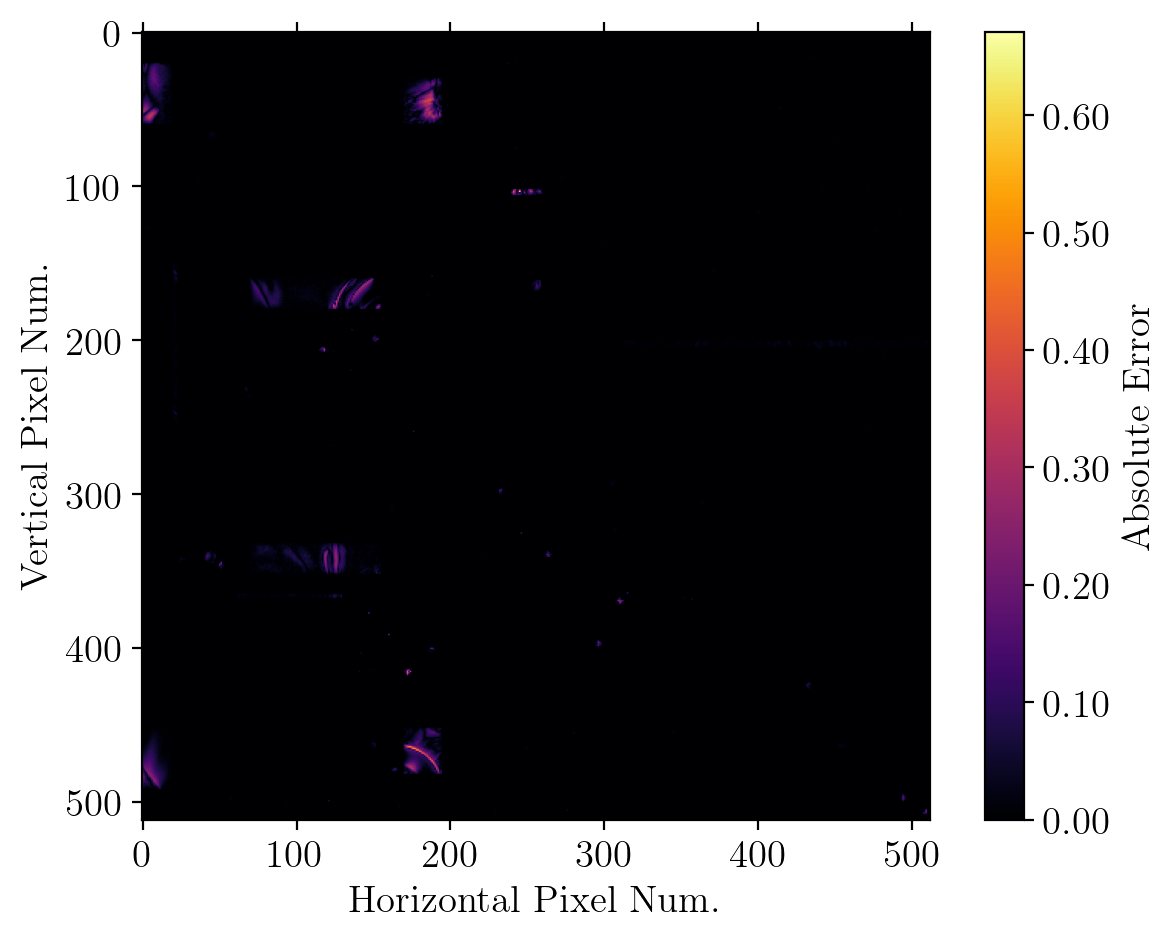

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_result-image_orig), cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)


plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

Now let's try an alternative image reconstruction using kriging. In addition to giving us a "fixed" image, kriging gives us error estimates!

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from sklearn.model_selection import train_test_split

kernel = 1.*Matern(length_scale_bounds=(1e-05, 100.0), nu=0.5)
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=1e-1, normalize_y=True) # normalizn critical here!

In [8]:
# next two lines are thanks to the discussion here: https://stackoverflow.com/questions/73162794/reconstructing-image-from-mask-coordinates
good_pixels = np.flip(np.column_stack(np.where(mask == 0)), axis=1) #getting coordinates of uncorrupted pixels

good_values = image_defect[mask==0]

X_train, X_test, Y_train, Y_test = train_test_split(good_pixels, good_values, train_size=0.01)

pred_pixels = np.flip(np.column_stack(np.where(mask > 0)), axis=1)#getting coordinates of pixels outside the mask

In [9]:
gaussian_process.fit(X_train, Y_train); 

In [10]:
gaussian_process.kernel_

1.02**2 * Matern(length_scale=60.4, nu=0.5)

In [11]:
image_kriged = image_defect.copy()

kriged_pixels, std = gaussian_process.predict(pred_pixels, return_std=True)

cnt = 0
for pixel in pred_pixels:
    image_kriged[pixel[1], pixel[0]] = kriged_pixels[cnt]
    cnt+=1

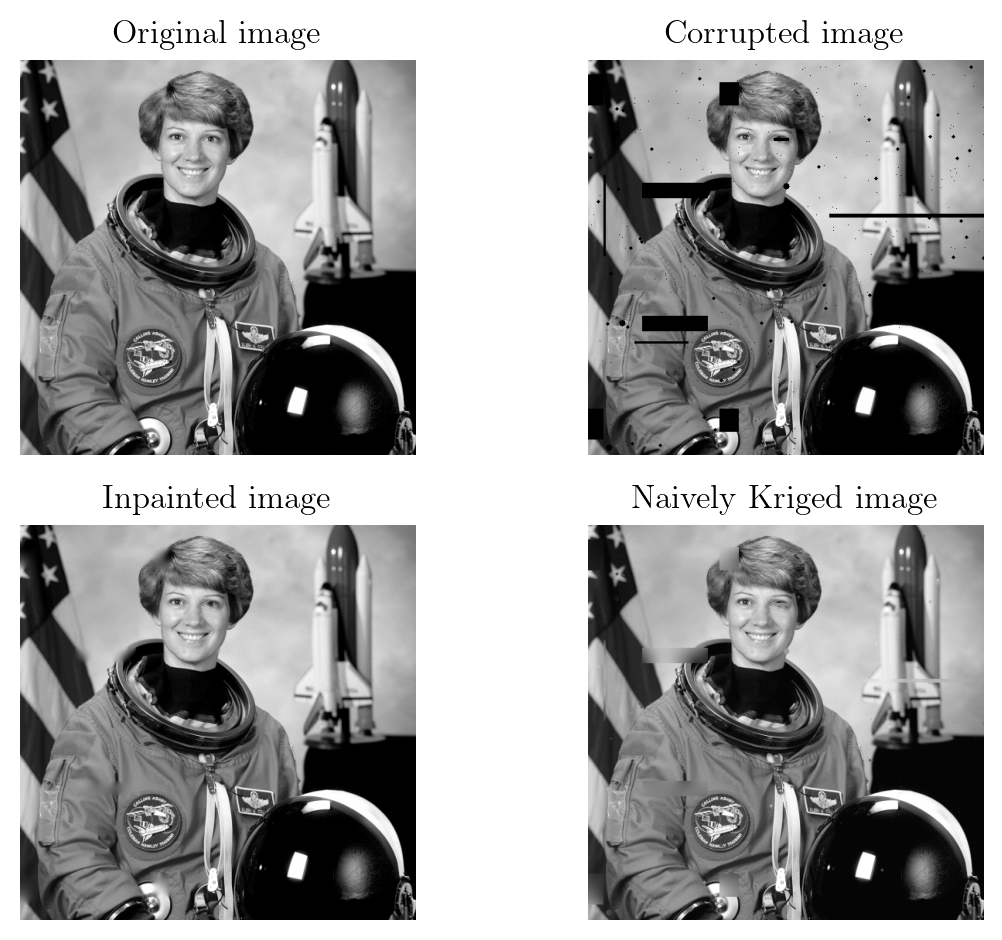

In [24]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Corrupted image')
ax[1].imshow(image_defect, cmap=plt.cm.gray)

ax[2].set_title('Inpainted image')
ax[2].imshow(image_result, cmap=plt.cm.gray)

ax[3].set_title('Naively Kriged image')
ax[3].imshow(image_kriged, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

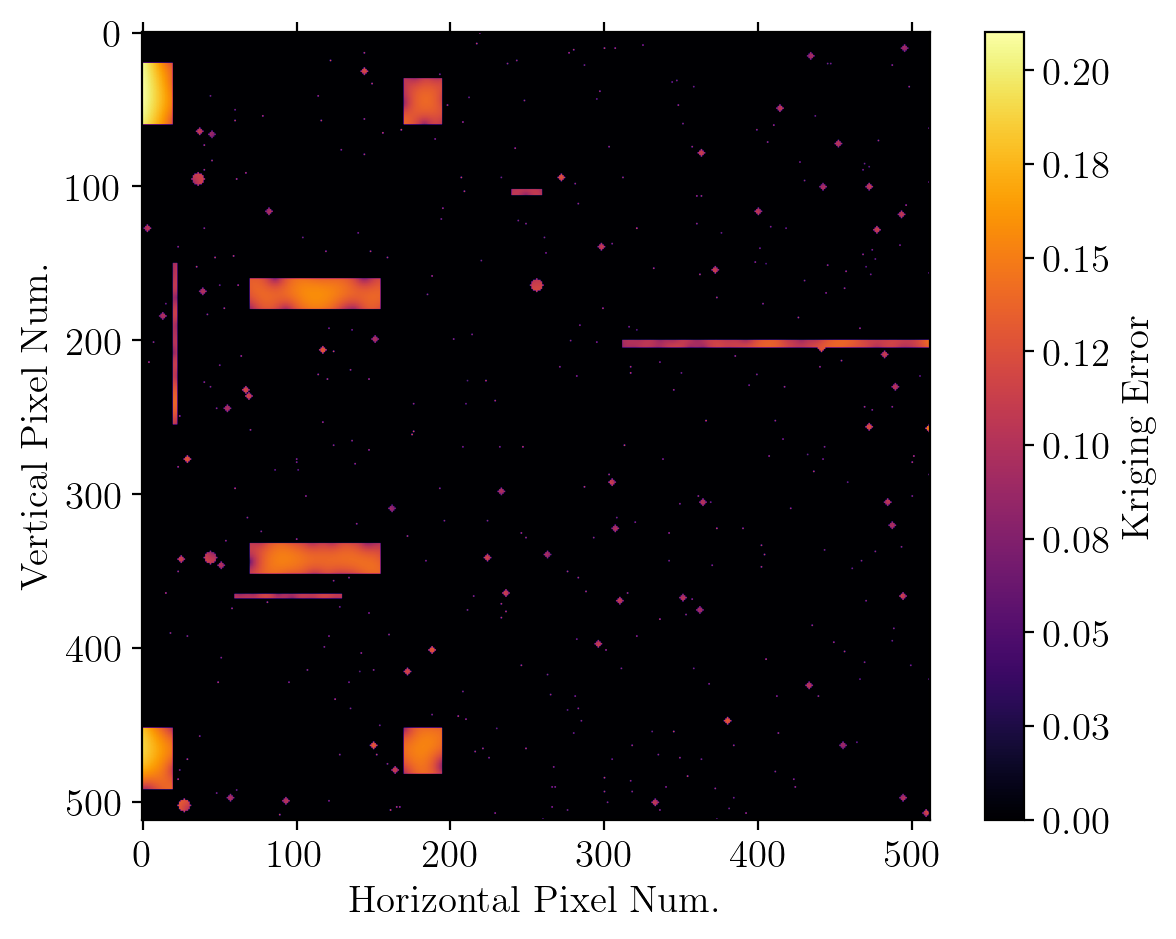

In [13]:
# plot theoretical predictions of kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

kriging_error = np.zeros_like(image_orig)

cnt = 0
for pixel in pred_pixels:
    kriging_error[pixel[1], pixel[0]] = std[cnt]
    cnt+=1

last = ax.imshow(kriging_error, cmap='inferno')

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Kriging Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

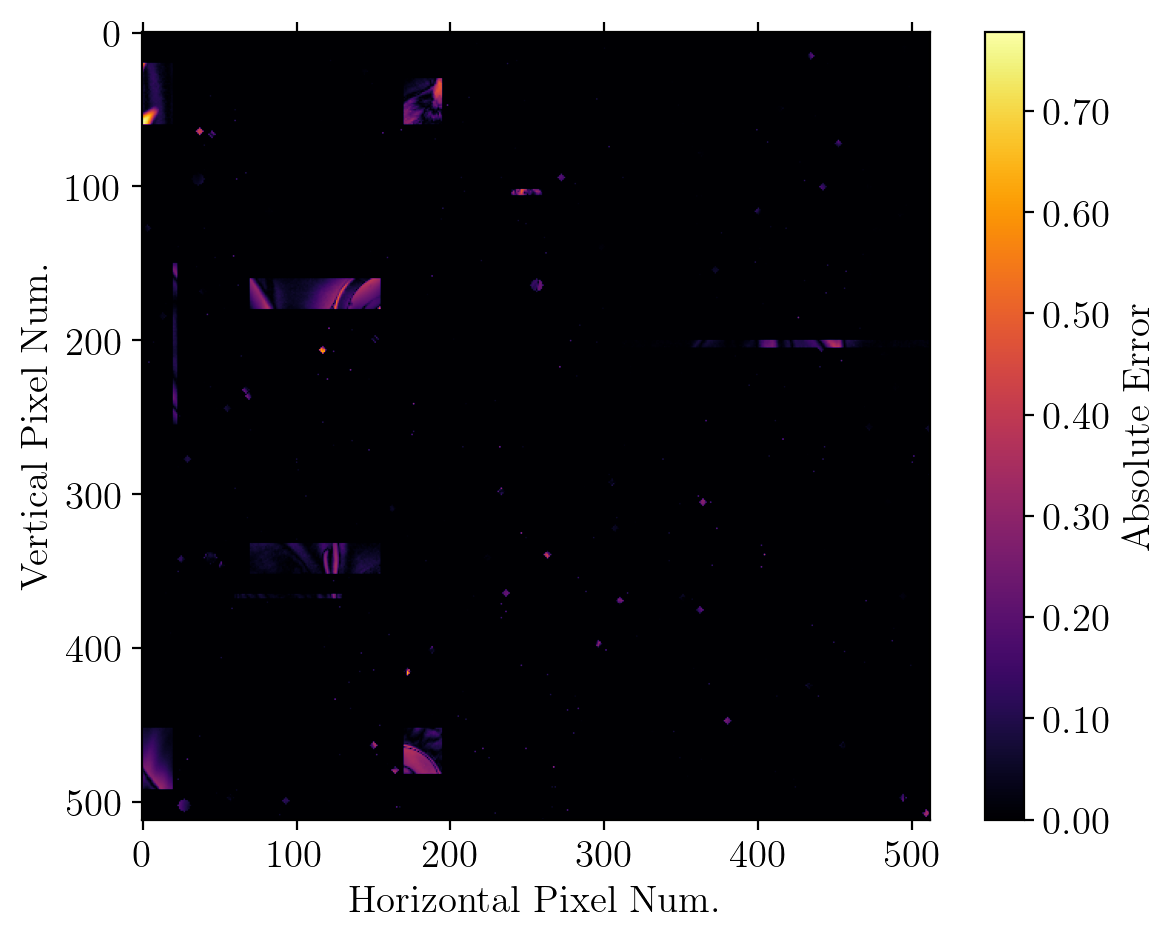

In [14]:
# plot actual kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_kriged-image_orig), cmap='inferno') #, clim=(0,0.15))

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()

In [15]:
from skimage.graph import pixel_graph
import networkx as nx
amat = pixel_graph(image_defect)
pg = nx.from_scipy_sparse_array(amat[0])

In [16]:
# functions for switching between image (pixel coord) and graph (node) representations
def label_to_coord(node):
    out = np.zeros((2), dtype=int)
    out[1] = int(node/512)
    out[0] = node % 512
    return out

def coord_to_label(pixel):
    out = pixel[...,1]*512 + pixel[...,0]%512
    return np.array(out, dtype=int)

In [17]:
# get node labels of the masked pixels
mask_labels = coord_to_label(pred_pixels)

In [18]:
# function that takes in a pixel P and outputs all coordinates of all other pixels that can be used to krige the image
# intensity at P
def get_good_nbhrs(pixel, n = 12):

    # get node number of pixel
    my_node = coord_to_label(pixel)
    
    # get immediate neighbours
    nbhr_nodes = np.array(list(pg.neighbors(int(my_node))))

    known_nbhr_nodes = nbhr_nodes[~np.isin(nbhr_nodes, mask_labels)]

    # if there's not enough nearby known pixels to krige, then invite more neighbors 
    while np.shape(known_nbhr_nodes)[0] < n:

        for node in nbhr_nodes:

            nbhr_nodes = np.append(nbhr_nodes, np.array(list(pg.neighbors(node))))

        nbhr_nodes = np.unique(nbhr_nodes[nbhr_nodes != my_node]) # remove the repeated values and the original node

        known_nbhr_nodes = nbhr_nodes[~np.isin(nbhr_nodes, mask_labels)]

    return np.array([label_to_coord(node) for node in known_nbhr_nodes]) # issues with int() only working on scalars cascase & require a loop here

In [25]:
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, ExpSineSquared, ConstantKernel
from sklearn.exceptions import ConvergenceWarning
from sklearn import preprocessing

import warnings
warnings.filterwarnings("error")

def extract_training_data(pixel, n = 4):
    X_train_loc = get_good_nbhrs(pixel, n=n) # identify which nearby pixels are suitable for training

    num_train = np.shape(X_train_loc)[0]

    Y_train_loc = np.zeros(num_train) # extract sub-image consisting of training pixels
    
    for k in range(0,num_train):
        training_pixel = X_train_loc[k]
        Y_train_loc[k] = image_defect[training_pixel[1], training_pixel[0]]

    return X_train_loc, Y_train_loc

def krige_pixel(pixel):

    #kernel = ConstantKernel(constant_value=1.0, constant_value_bounds=(0, 100000.0))
    kernel = 1*Matern(length_scale_bounds=(1e-6, 1e2), nu=0.5)
    #kernel = 1.*RationalQuadratic(length_scale=1.0, alpha=1.0, length_scale_bounds=(1e-05, 100000.0), alpha_bounds=(1e-05, 100000.0))
    #kernel = 1.*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))

    gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, alpha=1e-4, normalize_y=True) # normalizn critical here!

    X_train_loc, Y_train_loc = extract_training_data(pixel, n = 32)

    try: 
        
        #scaler = preprocessing.StandardScaler().fit(X_train_loc)
        #X_scaled = scaler.transform(X_train_loc)
    
        gaussian_process.fit(X_train_loc/512., Y_train_loc); 

        out =  gaussian_process.predict(pixel.reshape(1,-1)/512, return_std=False)

        #print("kernel fit worked for pixel", coord_to_label(pixel))

    except ConvergenceWarning: 

        #print("kernel fit failed for pixel", coord_to_label(pixel))

        X_train_loc, Y_train_loc = extract_training_data(pixel, n = 64)

        try:

            gaussian_process.fit(X_train_loc/512., Y_train_loc); 

            out =  gaussian_process.predict(pixel.reshape(1,-1)/512, return_std=False)

        except ConvergenceWarning:

            #print("refined kernel fit failed for pixel", coord_to_label(pixel))

            X_train_loc, Y_train_loc = extract_training_data(pixel, n = 128)

            try:

                gaussian_process.fit(X_train_loc/512., Y_train_loc); 
            
                out =  gaussian_process.predict(pixel.reshape(1,-1)/512, return_std=False)

            except ConvergenceWarning:

                #print("even more refined kernel fit failed for pixel", coord_to_label(pixel), '!!!!!!!!!!')

                out = None

                pass
    
    return out

In [26]:
image_kriged_loc = image_defect.copy()

fail_cnt = 0. 

for pixel in pred_pixels:
    try: 
        image_kriged_loc[pixel[1], pixel[0]] = krige_pixel(pixel).item() # item() is there because of silly issues with python scalars
    except AttributeError:
        fail_cnt += 1
        pass
        
print('fail percentage = ',100.*fail_cnt/np.shape(pred_pixels)[0], '%')

fail percentage =  0.8275862068965517 %


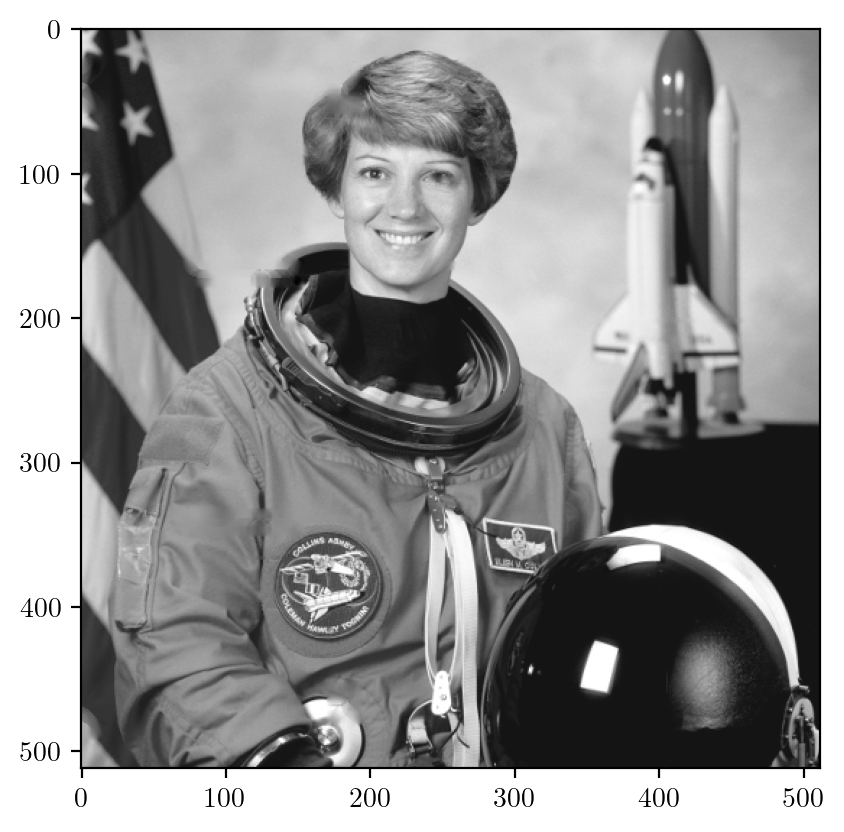

In [27]:
plt.imshow(image_kriged_loc, cmap=plt.cm.gray)
plt.show()

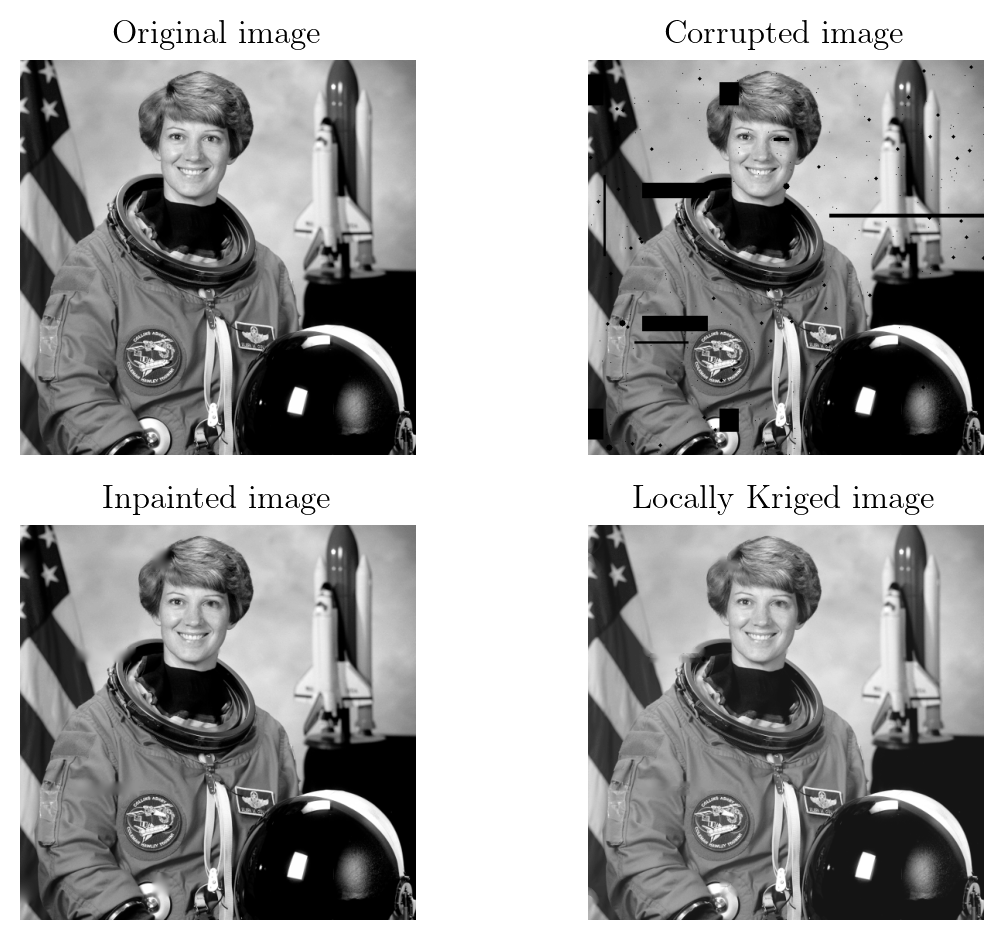

In [28]:
fig, axes = plt.subplots(ncols=2, nrows=2)
ax = axes.ravel()

ax[0].set_title('Original image')
ax[0].imshow(image_orig, cmap=plt.cm.gray)

ax[1].set_title('Corrupted image')
ax[1].imshow(image_defect, cmap=plt.cm.gray)

ax[2].set_title('Inpainted image')
ax[2].imshow(image_result, cmap=plt.cm.gray)

ax[3].set_title('Locally Kriged image')
ax[3].imshow(image_kriged_loc, cmap=plt.cm.gray)

for a in ax:
    a.axis('off')

fig.tight_layout()
plt.show()

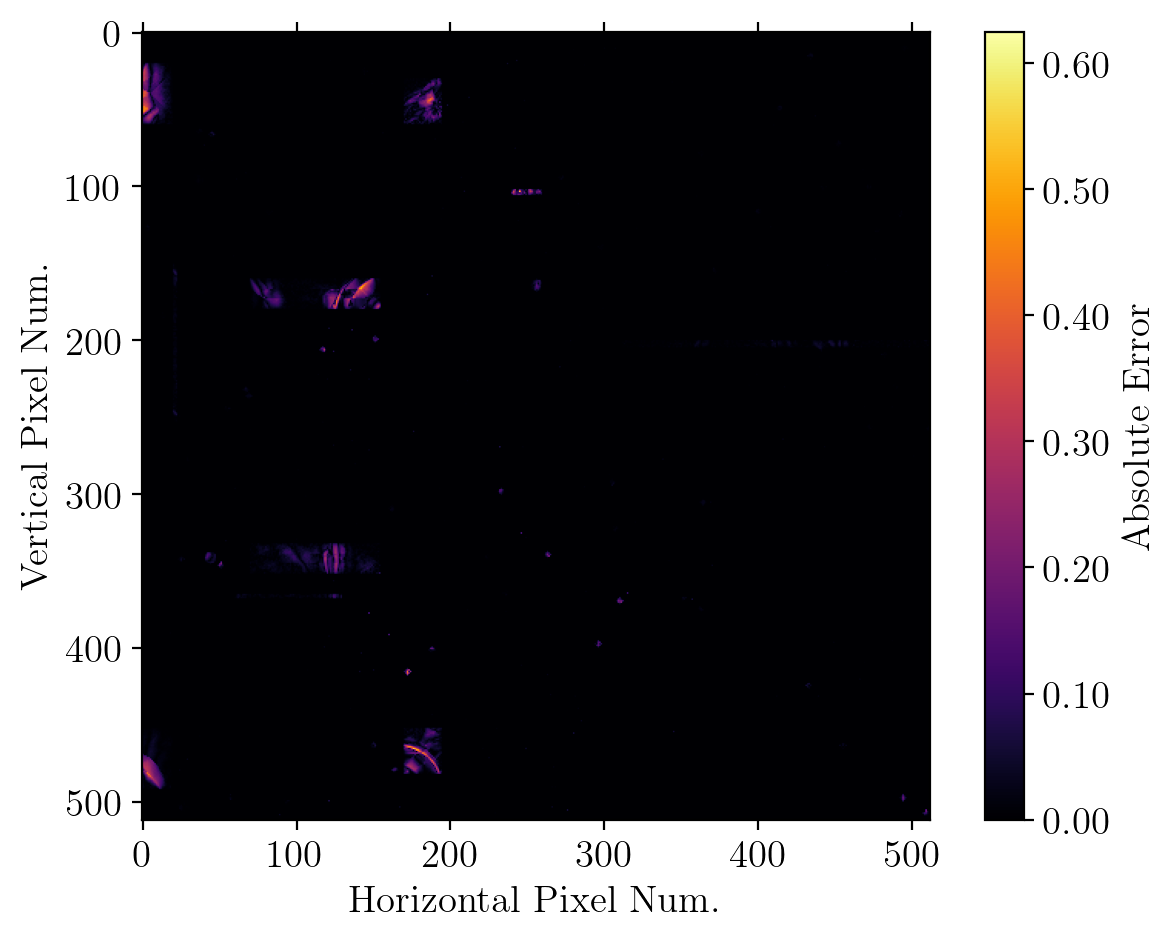

In [29]:
# plot actual kriging error
fig, ax = plt.subplots(ncols=1, nrows=1)

last = ax.imshow(np.abs(image_kriged_loc-image_orig), cmap='inferno') #, clim=(0,0.15))

plt.xlabel(r"Horizontal Pixel Num.", fontsize=14, color = textcolor)
plt.ylabel(r"Vertical Pixel Num.", fontsize=14, color=textcolor)

plt.tick_params(axis='x', which='both', top='off', color = textcolor)
plt.xticks(fontsize=14, rotation=0, color = textcolor)
plt.yticks(fontsize=14, rotation=0, color = textcolor)

cbar = plt.colorbar(last,  format='%.2f',fraction=0.046, pad=0.05)
cbar.ax.tick_params(labelsize=14, color=textcolor) 
cbar.ax.set_ylabel(r'Absolute Error', fontsize=14, color=textcolor)
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color=textcolor)

fig.tight_layout()
plt.show()